Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/TP_DnCNN.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FTP_DnCNN.ipynb&branch=main" target="_blank">Rosenblatt</a>

# TP.  Réseau DnCNN pour le débruitage

Ce notebook reprend le contenu du notebook/TP sur le débruitage. Le but va être d'implémenter et de tester le modèle DnCNN en remplacement des réseaux convolutionnels simples testés précédemment.
<br>
<br>
<br>
## Imports des librairies et configuration

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import math
import numpy as np
import matplotlib.pyplot as plt

# Configuration du device : CPU ('cpu') ou GPU ('cuda:0' ou cuda:1').
# Si on execute sur une machine sans GPU, les calculs seront plus lents.
# N.B. Le serveur Rosenblatt dispose de deux GPUs, on peut donc spécifier
# 'cuda:0' ou 'cuda:1' dans la ligne ci-dessous. Si beaucoup d'utilisateurs
# utilisent le même GPU en même temps, ça peut évidemment ralentir les calculs!
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

# Dossier où sont téléchargées les données. Fonctionne sur le serveur Rosenblatt,
# sinon il faut spécifier un dossier local et y avoir placé les données qui ne sont
# directement téléchargeables avec Pytorch (en l'occurrence FER2013)
dataroot = '/home/jupyter-glaunes/data_M2MMAS/'

# Hyper paramètres

# nombre d'époques. On choisit 1 seule époque pour aller plus vite dans les premiers exemples
# qui sont simples. Ensuite plus bas on augmentera à 3 puis à 5. La bonne pratique serait de fixer
# un nombre d'époques maximal grand (e.g. 100) et de faire de l'early stopping avec un test de
# validation.
num_epochs = 1

# taille des batchs et learning rate: on fixe des valeurs pour tous les essais mais on pourrait en tester d'autres.
batch_size = 16
learning_rate = 0.001

device: cuda:0


## Datasets d'images

In [ ]:
# N.B. par rapport au notebook de départ, on encapsule la déclaration du dataset dans une fonction.
# Ceci permettra de refaire des tests plus loin avec des données, modèles ou paramètres différents
# sans avoir à recopier tout le code. On fera la même chose plus loin pour le code d'entraînement.

def get_dataset(dataset):
    if dataset == "MNIST":
        train_dataset = torchvision.datasets.MNIST(root=dataroot, train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)
        test_dataset = torchvision.datasets.MNIST(root=dataroot, train=False,
                                                  transform=transforms.ToTensor(),
                                                  download=True)
        n_channels = 1
    elif dataset == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(root=dataroot, train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)
        test_dataset = torchvision.datasets.CIFAR10(root=dataroot, train=False,
                                                  transform=transforms.ToTensor(),
                                                  download=True)
        n_channels = 3
    elif dataset == "FER2013":
        train_dataset = torchvision.datasets.FER2013(root=dataroot, split="train",
                                                     transform=transforms.ToTensor())
        test_dataset = torchvision.datasets.FER2013(root=dataroot, split="test",
                                                    transform=transforms.ToTensor())
        n_channels = 1
    elif dataset == "Imagenette":
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.RandomCrop(size=(20,32),pad_if_needed=True)])
        train_dataset = torchvision.datasets.Imagenette(root=dataroot, split="train",
                                                        transform=transform,
                                                        download=True)
        test_dataset = torchvision.datasets.Imagenette(root=dataroot, split="val",
                                                       transform=transform,
                                                       download=True)
        n_channels = 3

    # Data loader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True)

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)
    return train_dataset, train_loader, test_dataset, test_loader, n_channels

dataset = "MNIST"
train_dataset, train_loader, test_dataset, test_loader, n_channels = get_dataset(dataset)

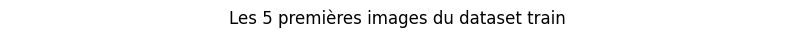

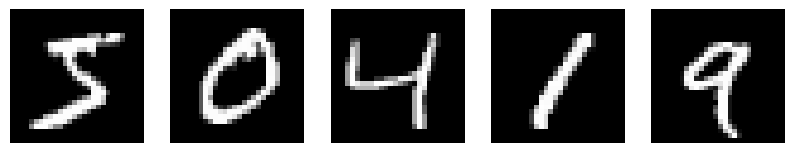

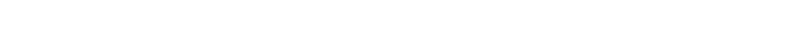

In [ ]:
# affichage de quelques images
def show_images(images, nrows=1, title=None, width=10):
    nb_ims = images.shape[0]
    plt.figure(figsize=(width,0.1))
    plt.axis("off")
    plt.title(title)
    plt.show()
    ncols = math.ceil(nb_ims/nrows)
    plt.figure(figsize=(width,width/ncols))
    for k in range(nb_ims):
       plt.subplot(nrows, ncols, k+1)
       plt.imshow(images[k].permute((1,2,0)), cmap="gray")
       plt.axis("off")
    plt.show()
    plt.figure(figsize=(width,0.3))
    plt.axis("off")
    plt.show()

def load_batch(dataset, n):
  return torch.stack([dataset[k][0] for k in range(n)])

train_images_sample = load_batch(train_dataset, 5)
show_images(train_images_sample, title="Les 5 premières images du dataset train")

## Fonctions pour simuler la dégradation des images

In [ ]:
# bruit gaussien
def gaussian_noise(images,sigma=.1):
    res = images + torch.randn(images.shape, device=images.device)*sigma
    res = res.clip(0,1)
    return res

# bruit "Salt and Pepper"
def salt_and_pepper(images,prob=.1):
    images_noisy = images.clone().permute((0,2,3,1))
    rnd = torch.rand(images_noisy.shape[:-1])
    images_noisy[rnd<prob/2,:] = 0
    images_noisy[rnd>1-prob/2,:] = 1
    return images_noisy.permute((0,3,1,2))

# suppression d'un bloc de pixel (pour l'inpainting)
def random_remove(images, size=(16,16)):
    images_out = images.clone().permute((0,2,3,1))
    i = torch.randint(images_out.shape[1]-size[0], (images_out.shape[0],))
    j = torch.randint(images_out.shape[2]-size[0], (images_out.shape[0],))
    for k in range(images_out.shape[0]):
        images_out[k,i[k]:(i[k]+size[0]),j[k]:(j[k]+size[1]),:] = 0
    return images_out.permute((0,3,1,2))

## Réseaux CNN simples pour le débruitage

Les réseaux suivants sont ceux testés lors du premier TP

In [ ]:
# On définit une classe pour le réseau CNN

class ConvNet(nn.Module):
    def __init__(self, n_channels):
        super(ConvNet, self).__init__()
        # entrée = (h,w,n_channels)
        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU())
        # (h,w,16)
        self.layer2 = nn.Sequential(
                nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(32),
                nn.ReLU())
        # (h,w,32)
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, n_channels, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [ ]:
# On crée une instance du réseau
model = ConvNet(n_channels).to(device)

## Fonction de perte et optimiseur

Ici la fonction de perte (loss function) est différente, puisqu'on ne compare plus des classes mais des images. On peut utiliser le critère des moindres carrés : Mean Square Error (MSE) loss.

In [ ]:
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Entraînement du réseau.

In [ ]:
# On écrit une fonction pour l'entraînement du réseau

def train_network(train_loader, corrupt_fun, model, lossfun,
                  optimizer, num_epochs, print_progress=True, plot_loss=True):
    print("beginning training...")
    total_step = len(train_loader)
    rec_loss = np.zeros((num_epochs,len(train_loader)))
    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(train_loader):
            images = images.to(device)
            images_noisy = corrupt_fun(images)

            # Forward pass
            outputs = model(images_noisy)
            loss = lossfun(outputs,images)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            rec_loss[epoch,i] = loss.item()

            if print_progress and ((i+1) % 100 == 0):
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    print("training done")
    if plot_loss:
        plt.figure(figsize=(8,4))
        plt.plot(rec_loss.flatten())
        plt.title("loss vs iterations")
    return model, rec_loss

In [ ]:
# On définit une fonction pour le test (on s'en servira plusieurs fois):

def test_model(model, test_dataset, corrupt_fun):
    test_images_sample = load_batch(test_dataset, 5)
    test_images_sample_corrupt = corrupt_fun(test_images_sample)

    outputs = model(test_images_sample_corrupt.to(device)).detach().cpu()

    show_images(test_images_sample_corrupt, title="Les 5 premières images test, dégradées (entrée du réseau)")
    show_images(outputs, title="sorties du réseau")
    show_images(test_images_sample, title="Les 5 premières images test")

In [ ]:
# Données FER2013:
dataset = "FER2013"
train_dataset, train_loader, test_dataset, test_loader, n_channels = get_dataset(dataset)

beginning training...
training done


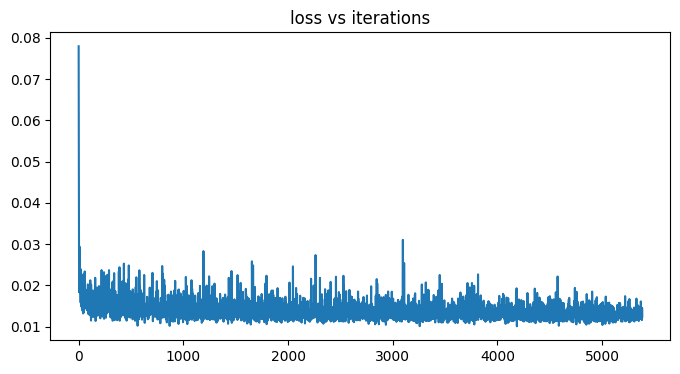

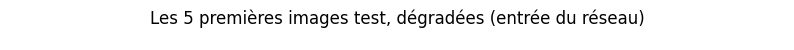

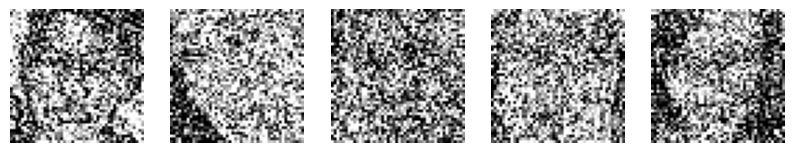

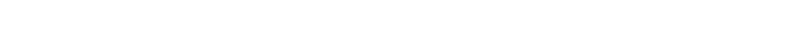

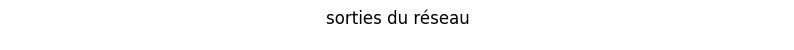

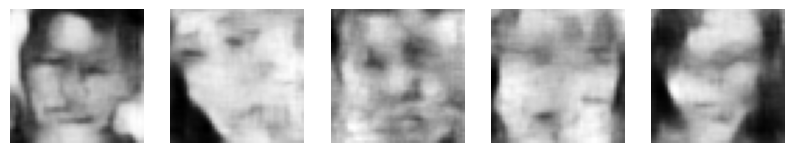

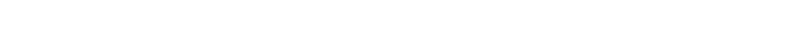

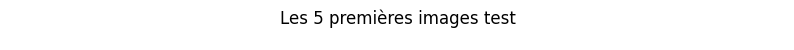

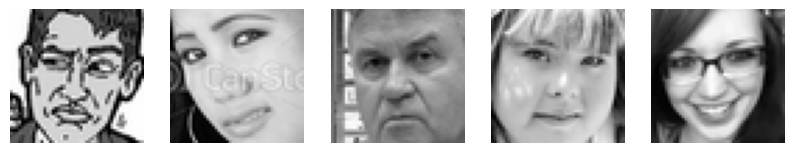

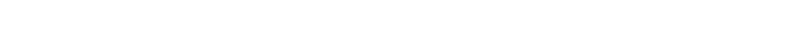

In [ ]:
# Test avec bruit gaussien fort:
corrupt_fun = lambda x : gaussian_noise(x,sigma=.5)
model = ConvNet(n_channels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model, rec_loss = train_network(train_loader, corrupt_fun, model,
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

In [ ]:
# Réseau CNN
class ConvNet(nn.Module):
    def __init__(self, n_channels, n_layers):
        super(ConvNet, self).__init__()
        # entrée = (h,w,n_channels)
        self.layer_input = nn.Sequential(
            nn.Conv2d(n_channels, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU()) # (h,w,16)
        # (h,w,16)
        self.layer_intern = []
        for i in range(n_layers-2):
            layer = nn.Sequential(
                nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(16),
                nn.ReLU())
            self.layer_intern.append(layer)
        # La commande suivante est nécessaire pour "enregistrer" la liste des couches
        # qu'on vient de définir comme une partie du réseau, sinon PyTorch ne saura pas
        # que les paramètres de ces couches sont à optimiser.
        self.layer_intern = nn.ModuleList(self.layer_intern)
        # (h,w,16)
        self.layer_output = nn.Sequential(
            nn.Conv2d(16, n_channels, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.layer_input(x)
        for i in range(len(self.layer_intern)):
            out = self.layer_intern[i](out)
        out = self.layer_output(out)
        return out

beginning training...
training done


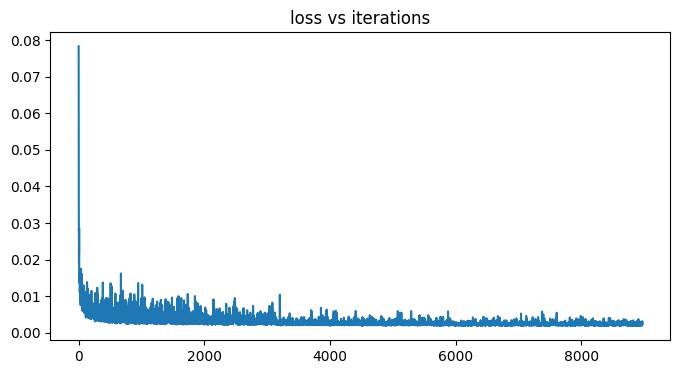

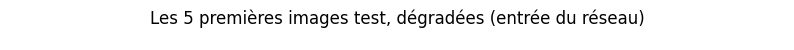

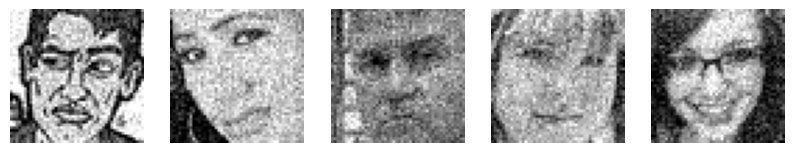

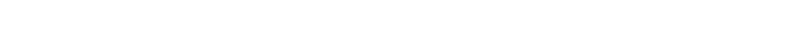

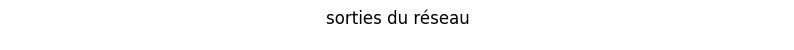

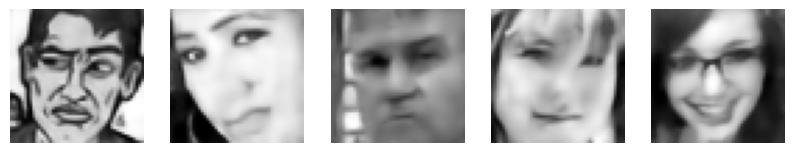

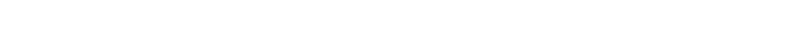

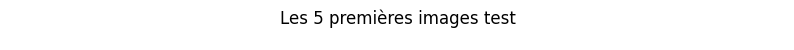

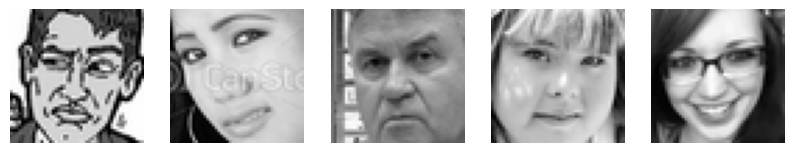

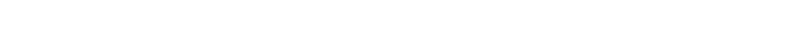

In [ ]:
# On teste un modèle à 10 couches sur FER2013 pour le denoising
dataset = "FER2013"
train_dataset, train_loader, test_dataset, test_loader, n_channels = get_dataset(dataset)
corrupt_fun = lambda x : gaussian_noise(x,.1)
model = ConvNet(n_channels,10).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model, rec_loss = train_network(train_loader, corrupt_fun, model,
                                lossfun, optimizer, num_epochs, print_progress=False)
test_model(model, test_dataset, corrupt_fun)

__Question__ Implémenter le réseau DnCNN en vous basant sur l'architecture décrite dans l'article, et tester le réseau pour les préblèmles de débruitage précédents.